Training Accuracy: 1.00
Testing Accuracy: 0.92
Real Testing Accuracy: 0.40


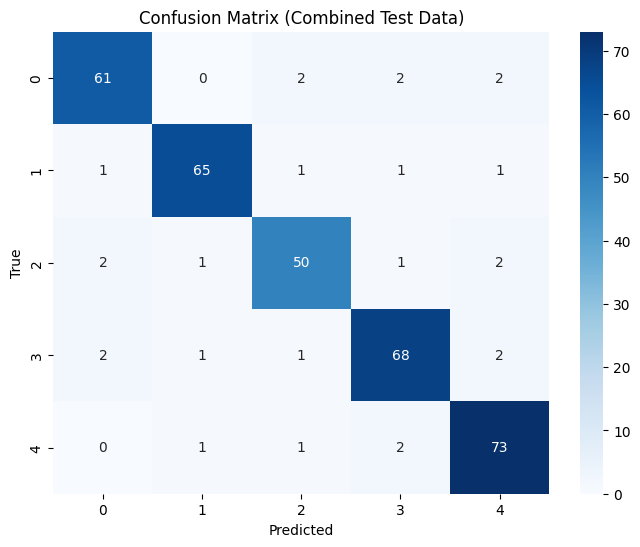

False Negative Rate (FNR) for each class:
Class 0: FNR = 0.09
Class 1: FNR = 0.06
Class 2: FNR = 0.11
Class 3: FNR = 0.08
Class 4: FNR = 0.05
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92        67
           1       0.96      0.94      0.95        69
           2       0.91      0.89      0.90        56
           3       0.92      0.92      0.92        74
           4       0.91      0.95      0.93        77

    accuracy                           0.92       343
   macro avg       0.92      0.92      0.92       343
weighted avg       0.92      0.92      0.92       343



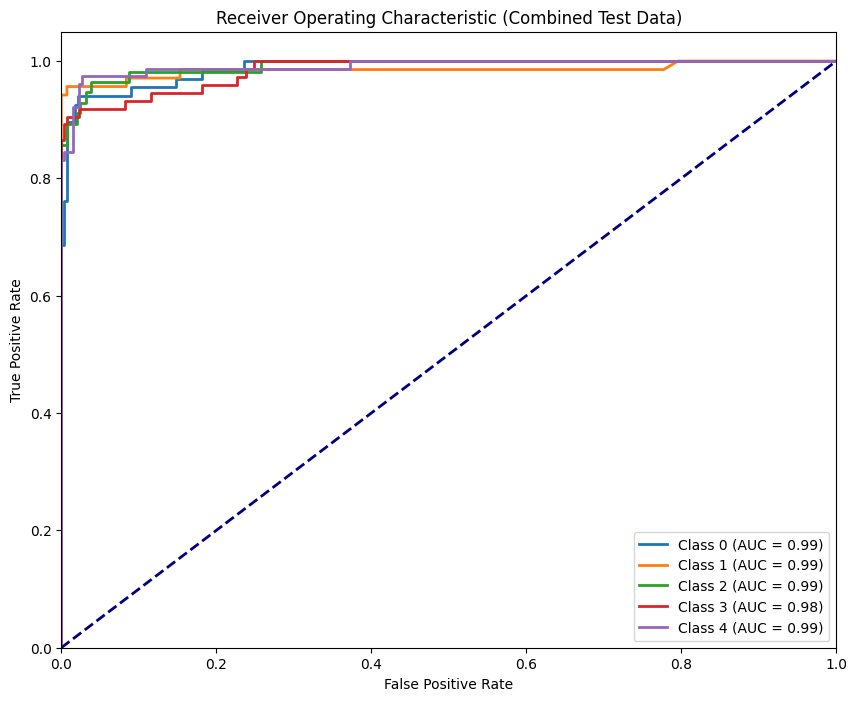

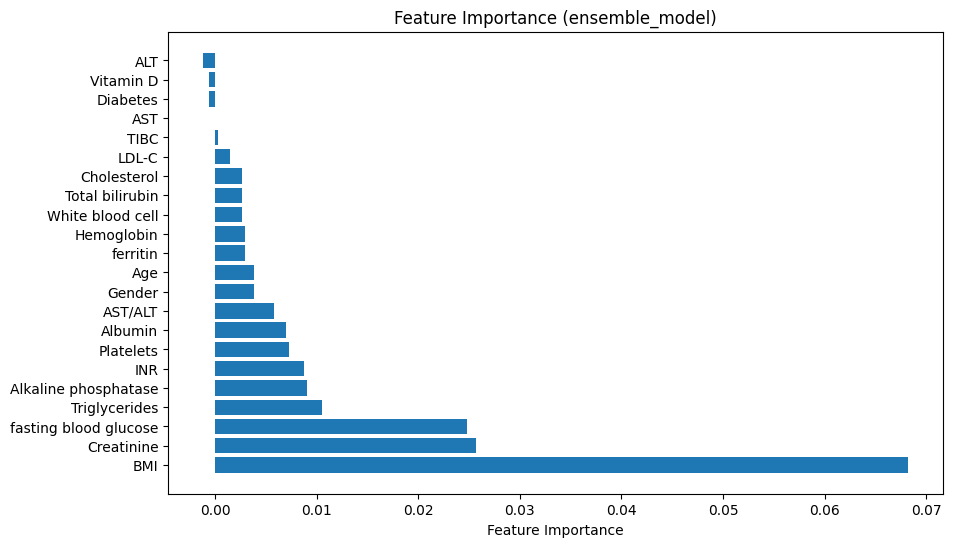

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns
import numpy as np
import pandas as pd

# Load and preprocess the data
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
#data = data.drop(columns=['name'])
data.fillna(data.mean(numeric_only=True), inplace=True)

# Split data into features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load new test data and combine
test_data_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_file.fillna(test_data_file.mean(numeric_only=True), inplace=True)
X_test_data_file = test_data_file.drop('steato score', axis=1)
y_test_data_file = test_data_file['steato score']

X_test_combined = pd.concat([X_test, X_test_data_file], ignore_index=True)
y_test_combined = pd.concat([y_test, y_test_data_file], ignore_index=True)



#  Random Forest model with hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(rf_model, param_dist_rf, n_iter=10, cv=5, scoring='f1_weighted', random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf_model = random_search_rf.best_estimator_

#  Gradient Boosting model with hyperparameter tuning
gb_model = GradientBoostingClassifier(random_state=42)
param_dist_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [ 5,10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
random_search_gb = RandomizedSearchCV(gb_model, param_dist_gb, n_iter=10, cv=5, scoring='f1_weighted', random_state=42)
random_search_gb.fit(X_train, y_train)
best_gb_model = random_search_gb.best_estimator_

#  Select the best model
best_model = best_rf_model if random_search_rf.best_score_ > random_search_gb.best_score_ else best_gb_model


# Check accuracy on test set
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test_combined, y_test_combined)
real_test_acc = best_model.score(X_test_data_file, y_test_data_file)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"Real Testing Accuracy: {real_test_acc:.2f}")


#  Model prediction
y_pred_combined = best_model.predict(X_test_combined)

# Compute confusion matrix
cm_combined = confusion_matrix(y_test_combined, y_pred_combined)

#  Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Combined Test Data)')
plt.show()

# Compute FNR for each class
fnr_combined = {}
for i, cls in enumerate(best_model.classes_):
    FN = cm_combined[i, :].sum() - cm_combined[i, i]  # False negatives for class i
    TP = cm_combined[i, i]  # True positives for class i
    fnr_combined[cls] = FN / (FN + TP) if (FN + TP) != 0 else 0

print("False Negative Rate (FNR) for each class:")
for cls, rate in fnr_combined.items():
    print(f"Class {cls}: FNR = {rate:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, cls in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), best_model.predict_proba(X_test_combined)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Combined Test Data)')
plt.legend(loc="lower right")
plt.show()

# Permutation Importance (Ensemble Model)
results = permutation_importance(best_model, X_test_combined, y_test_combined, scoring='accuracy', n_repeats=10, random_state=42)
importance_scores = results.importances_mean
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importance_scores[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (ensemble_model)')
plt.show()



Top Features for Class 0 based on predict_proba:
Diabetes: 0.0000
Vitamin D: -0.0000
TIBC: -0.0006
ALT: -0.0020
LDL-C: -0.0038
INR: -0.0038
AST: -0.0047
ferritin: -0.0050
Gender: -0.0055
fasting blood glucose: -0.0064
White blood cell: -0.0067
Cholesterol: -0.0067
Hemoglobin: -0.0073
Age: -0.0079
Total bilirubin: -0.0079
Triglycerides: -0.0082
Creatinine: -0.0082
AST/ALT: -0.0102
Albumin: -0.0102
Alkaline phosphatase: -0.0125
Platelets: -0.0181
BMI: -0.0210


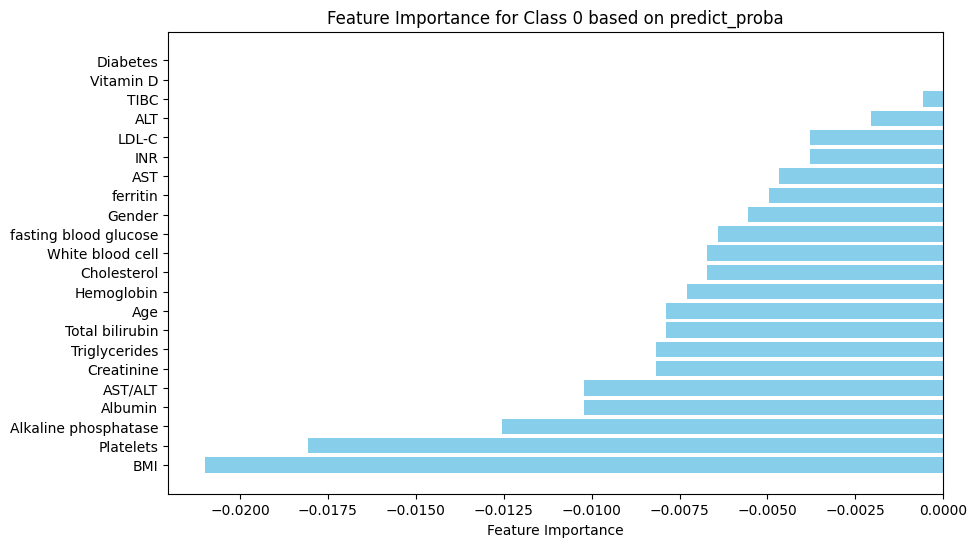


Top Features for Class 1 based on predict_proba:
fasting blood glucose: 0.0038
INR: 0.0000
Diabetes: -0.0006
TIBC: -0.0006
ALT: -0.0035
Creatinine: -0.0050
Gender: -0.0055
AST: -0.0055
LDL-C: -0.0058
Vitamin D: -0.0061
Hemoglobin: -0.0064
Triglycerides: -0.0076
White blood cell: -0.0079
Cholesterol: -0.0082
Total bilirubin: -0.0087
ferritin: -0.0090
BMI: -0.0093
Albumin: -0.0102
AST/ALT: -0.0102
Age: -0.0122
Alkaline phosphatase: -0.0140
Platelets: -0.0227


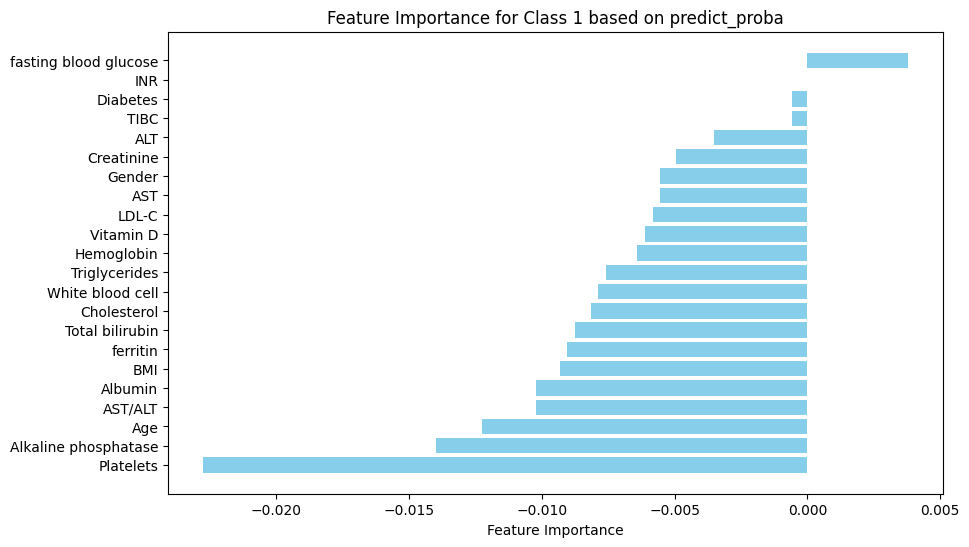


Top Features for Class 2 based on predict_proba:
fasting blood glucose: 0.0047
Creatinine: 0.0009
Diabetes: 0.0000
TIBC: -0.0006
AST: -0.0009
ALT: -0.0012
INR: -0.0017
Gender: -0.0026
Total bilirubin: -0.0026
LDL-C: -0.0032
Vitamin D: -0.0035
Triglycerides: -0.0038
White blood cell: -0.0041
Hemoglobin: -0.0055
BMI: -0.0055
Albumin: -0.0073
ferritin: -0.0076
Cholesterol: -0.0076
Alkaline phosphatase: -0.0090
Age: -0.0093
AST/ALT: -0.0111
Platelets: -0.0160


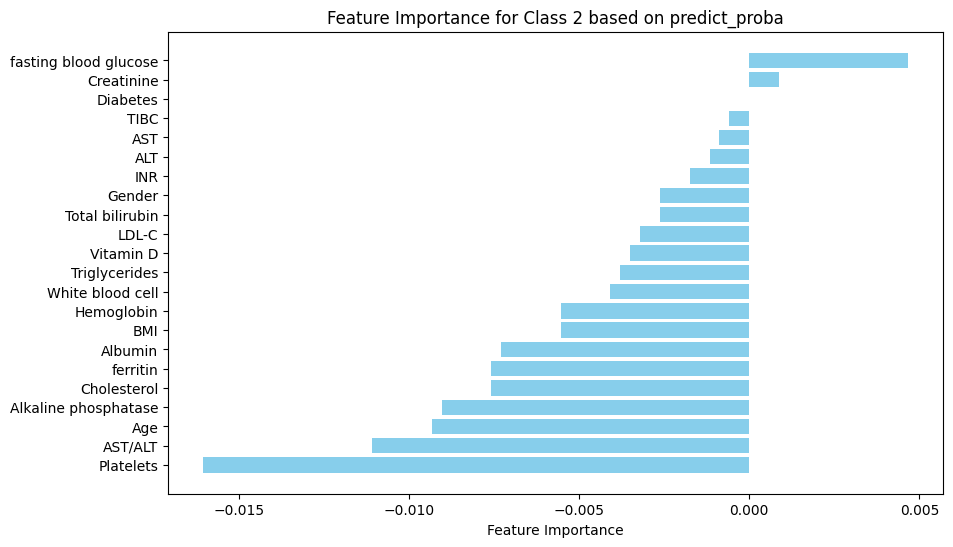


Top Features for Class 3 based on predict_proba:
fasting blood glucose: 0.0070
Diabetes: 0.0000
TIBC: -0.0006
ALT: -0.0035
INR: -0.0044
Triglycerides: -0.0044
BMI: -0.0047
Creatinine: -0.0047
Vitamin D: -0.0052
AST: -0.0052
Hemoglobin: -0.0052
Gender: -0.0055
LDL-C: -0.0064
White blood cell: -0.0070
AST/ALT: -0.0085
ferritin: -0.0085
Total bilirubin: -0.0093
Cholesterol: -0.0102
Age: -0.0111
Albumin: -0.0117
Alkaline phosphatase: -0.0122
Platelets: -0.0207


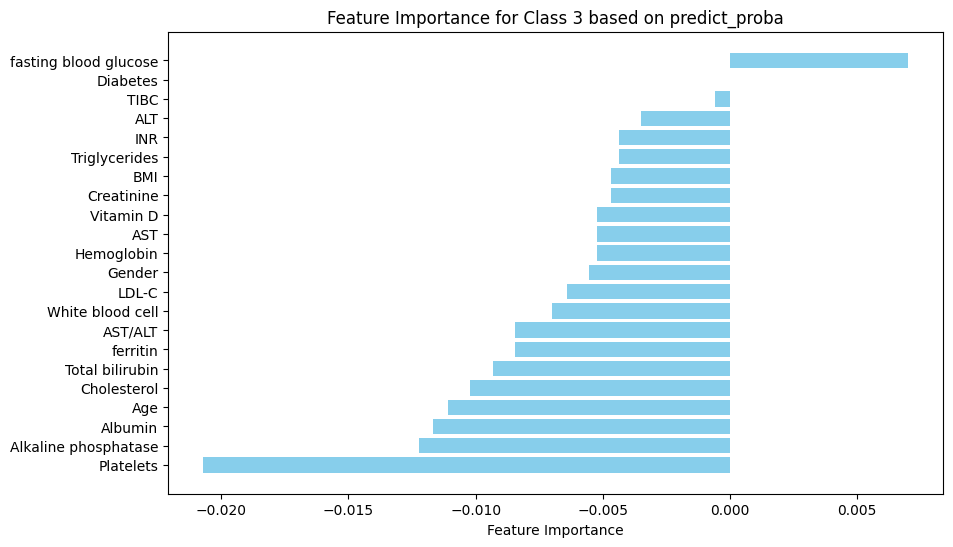


Top Features for Class 4 based on predict_proba:
fasting blood glucose: 0.0099
BMI: 0.0050
Hemoglobin: 0.0023
Diabetes: 0.0000
TIBC: 0.0000
Creatinine: -0.0006
AST/ALT: -0.0009
Cholesterol: -0.0009
Gender: -0.0015
White blood cell: -0.0023
ALT: -0.0026
Triglycerides: -0.0026
Vitamin D: -0.0032
ferritin: -0.0035
Age: -0.0041
AST: -0.0041
LDL-C: -0.0041
INR: -0.0044
Total bilirubin: -0.0061
Albumin: -0.0064
Platelets: -0.0085
Alkaline phosphatase: -0.0085


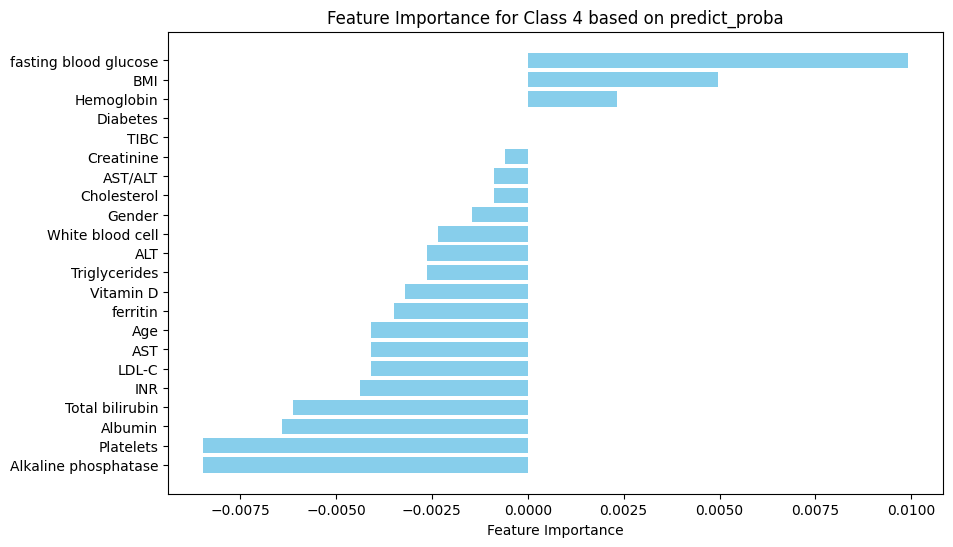

In [ ]:
from sklearn.inspection import permutation_importance
# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba = {}

# Loop over each class in the model
for class_index, cls in enumerate(best_model.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = best_model.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    importance_scores = permutation_importance(
        best_model, X_test_combined, y_binary,
        scoring='accuracy', n_repeats=10, random_state=42
    ).importances_mean

    # Sort by importance (descending)
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Save results for later use (optional)
    feature_importances_per_class_proba[cls] = {
        "features": sorted_features,
        "scores": sorted_scores
    }

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
